<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Swiss Post Sorting Centers Package Sorting Performance Analysis

This Notebook focuses on analyzing sorting center operations performance to identify congestion points and their causes.

also developing predictive models to foresee and prevent performance issues before they occur. 

This proactive strategy will help improve the overall performance of Swiss Post's sorting centers.

# Load libraries

In [1]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance

# common visualization module
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

# numeric library
import numpy as np

import os
import pandas as pd
from time import time as timer
import tarfile

import tensorflow as tf

from matplotlib import animation
from IPython.display import HTML
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from umap import UMAP

# Load Files 

we Load Data from only 3 Centers and only for few days 

Data is converted to Numbers to allow processing directly in the ML models 

all data is cleaned by removing all nulls and charachters 

In [2]:
# Load the CSV files for analysis
#file_path_1 = "DATA/dataFRA0711.csv"
#file_path_2 = "DATA/dataHAE1311.csv"
#file_path_3 = "DATA/dataDAI0711.csv"
file_path_1 = "DATA/dataFRA06.csv"
file_path_2 = "DATA/dataHAE06.csv"
file_path_3 = "DATA/dataDAI06.csv"
file_path_4 = "DATA/data1000.csv"

# Reading the datasets
df_fra = pd.read_csv(file_path_1)
df_hae = pd.read_csv(file_path_2)
df_dai = pd.read_csv(file_path_3)
df_1000 = pd.read_csv(file_path_4)


# Display the first few rows of each dataset to understand their structure
df_fra_head = df_fra.head()
df_hae_head = df_hae.head()
df_dai_head = df_dai.head()

# Combine the 3 datasets for uniform analysis
combined_df = pd.concat([df_fra, df_hae, df_dai])


df_fra_head
df_hae_head
df_dai_head

#data=combined_df
data=df_1000

combined_df


,CODS_IDENTCODE_AN,CODS_DIM1,CODS_DIM2,CODS_DIM3,CODS_GEW,CODS_ADR_PLZZZ_AN,CODS_CO_STATION,CODS_ZENT_NR,CODS_SD_RUTSCHE,DAY_15MIN,CODS_LERE_DAT,MINUTE_COUNTER,PROCESSING_TIME_MINUTES,SORTING_PERF_ISSUE
0,242455661,700,454,54,1480,449561,FRA-ACS18,3,R0109,202411061015,06/11/2024 10:26:25,447026,1,0
1,482169492,704,454,48,1520,568172,FRA-ACS18,3,R0109,202411061015,06/11/2024 10:26:15,447026,2,0
2,407572193,400,380,235,4700,23223,FRA-ACS21,3,R2515,202411061015,06/11/2024 10:26:16,447026,4,0
3,999133381,470,450,120,1060,629595,FRA-ACS21,3,R0109,202411061015,06/11/2024 10:26:04,447026,7,0
4,748472889,360,290,110,1480,421619,FRA-ACS21,3,R2319,202411061015,06/11/2024 10:26:37,447027,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170012,302468774,490,390,90,1280,712077,DAI-ACS13,1,R2419,202411061430,06/11/2024 14:38:26,447278,4,0
170013,225629123,170,110,55,120,869319,DAI-ACS13,1,R1223,202411061430,06/11/2024 14:38:22,447278,2,0
170014,822331195,410,360,55,820,49468,DAI-ACS13,1,R2704,202411061430,06/11/2024 14:38:25,447278,6,0
170015,804061373,400,310,110,1640,32705,DAI-ACS13,1,R1709,202411061430,06/11/2024 14:38:19,447278,6,0


# Column Summary:

### Shipment number (anonymized) SND_IDENTCODE

CODS_IDENTCODE_AN: Numeric (integer)

### Shipment dimensions: Length, width, and height (in millimeters) SND_CODS_DIM1,SND_CODS_DIM2, SND_CODS_DIM3 and Shipment weight: (n grams) SND_GEW and Zipcode anonymized 
 CODS_DIM1: Numeric (integer), CODS_DIM2: Numeric (integer), CODS_DIM3: Numeric (integer), CODS_GEW: Numeric (integer), CODS_ADR_PLZZZ_AN: Categorical (integer)

## Scanner station: Sorting station identifier CODS_CO_STATION

CODS_CO_STATION: Categorical (string/object) which scanner scanned the package in 

CODS_ZENT_NR: Categorical (integer) which center 

CODS_SD_RUTSCHE: Categorical (string/object) which chout it exited

## Scanning timestamps when the item first scanned in the sorting center CODS_COD_DAT 

DAY_15MIN: Categorical (integer) the time in 15 min chunks to identify where the bottelneck 

CODS_LERE_DAT: DATE (DATE) Time it left the chout center 

MINUTE_COUNTER: Numeric (integer) counting from 01.01.2024 to have the timestamp as number 

PROCESSING_TIME_MINUTES: Numeric (integer) how long it took to process the data 

## the processing time is longer than 10 min its considered performance issue == 1 else 0

SORTING_PERF_ISSUE: Categorical (integer)

# Anonymize and transform DATA

All sensitive data is anonymized from the DB query before copying to Python

Data is converted to numbers to enable direct processing in the ML models

All data is cleaned by removing all zeros and characters, so no data cleaning is required in Python

In [3]:

#def anonymize_identcode_numeric_consistent(identcode, max_digits=10):
    # Use SHA-256 hash, encode to hexadecimal integer, and then take modulus for consistency across sessions
 #   hash_value = int(hashlib.sha256(str(identcode).encode()).hexdigest(), 16)
  #  return hash_value % (10**max_digits)

# Apply this function to anonymize consistently across sessions
#combined_df['SND_IDENTCODE'] = combined_df['SND_IDENTCODE'].apply(anonymize_identcode_numeric_consistent)

#combined_df.head()

In [3]:
data=df_1000
# Engineer new column 
data['CODS_DIM_SUM'] = data['CODS_DIM1'] + data['CODS_DIM2'] + data['CODS_DIM3']
data = data.drop(columns=['CODS_DIM1', 'CODS_DIM2', 'CODS_DIM3'])


# Define the target variable and features
#numeric_columns = ['CODS_DIM1', 'CODS_DIM2', 'CODS_DIM3', 'CODS_GEW',
numeric_columns = ['CODS_DIM_SUM','CODS_GEW','PROCESSING_TIME_MINUTES','MINUTE_COUNTER']  
numeric_data = data[numeric_columns]
numerical_features = numeric_columns
categorical_features = ['CODS_ADR_PLZZZ_AN', 'CODS_CO_STATION', 'CODS_ZENT_NR', 'CODS_SD_RUTSCHE','DAY_15MIN','CODS_LERE_DAT','SORTING_PERF_ISSUE']  
Categorical_data = data[categorical_features]

# Labels are the values we want to predict
labels = np.array(data['PROCESSING_TIME_MINUTES'])
# Remove the labels from the features
# axis 1 refers to the columns8
features= data.drop('PROCESSING_TIME_MINUTES', axis = 1)
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

# descriptive statistics and BoxPlots distribution, spread, and potential outliers in the data

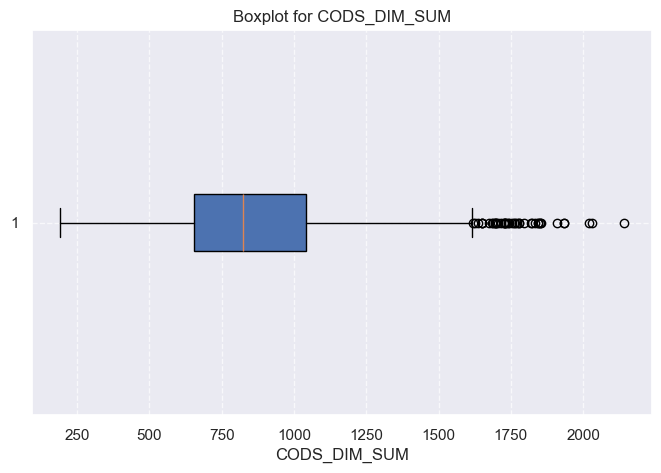

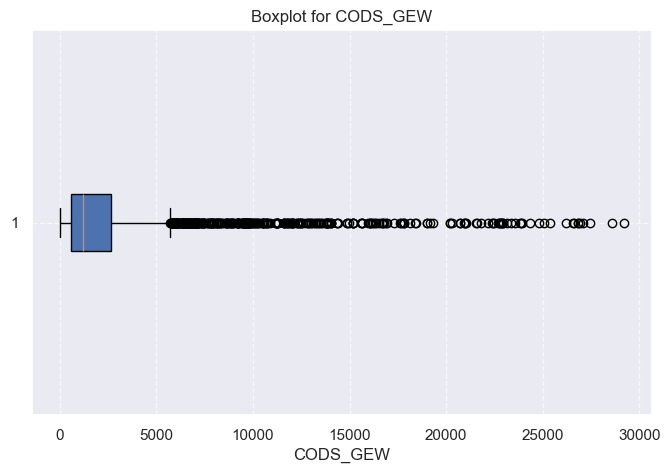

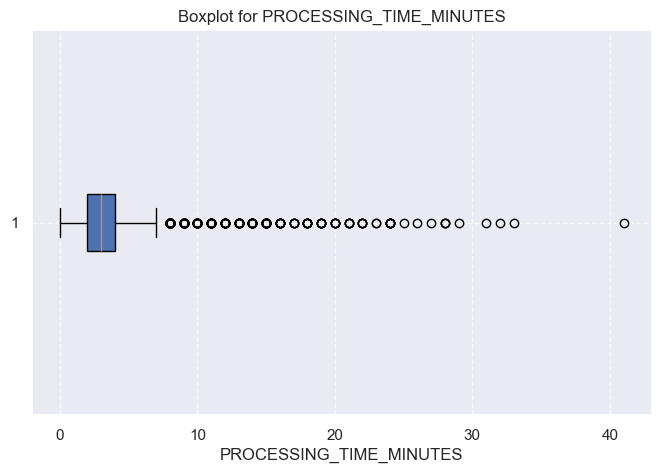

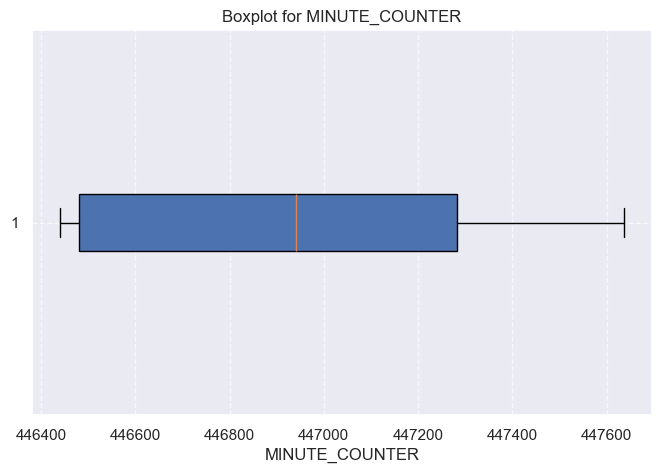

In [6]:
import matplotlib.pyplot as plt

# Creating boxplots for each numerical column
for column in numeric_columns:
    plt.figure(figsize=(8, 5))
    plt.boxplot(data[column], vert=False, patch_artist=True)
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


# linear regression model only for Numerical Columns 

In [35]:
data=combined_df    
#data=df_1000
# Engineer new column 
data['CODS_DIM_SUM'] = data['CODS_DIM1'] + data['CODS_DIM2'] + data['CODS_DIM3']
data = data.drop(columns=['CODS_DIM1', 'CODS_DIM2', 'CODS_DIM3'])


import statsmodels.api as sm

target = 'SORTING_PERF_ISSUE'  # Target variable
features = numeric_columns 


# Prepare data
X = data[features]
y = data[target]
    
# Add a constant for the intercept
X = sm.add_constant(X)
 
# Fit the regression model
model = sm.OLS(y, X).fit()
  
# Print summary of regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     SORTING_PERF_ISSUE   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                 4.436e+04
Date:                Fri, 22 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:42:12   Log-Likelihood:             1.4774e+05
No. Observations:              809022   AIC:                        -2.955e+05
Df Residuals:                  809017   BIC:                        -2.954e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

1. Model Fit Statistics

Dependent Variable: SORTING_PERF_ISSUE

R-squared: 0.180

Indicates that 18% of the variance in the dependent variable is explained by the model.

For binary outcomes, low R-squared values are common, as OLS isn't ideal for binary data (logistic regression is preferred).

2. Predictor Significance:

PROCESSING_TIME_MINUTES and CODS_GEW are the most impactful predictors, with statistically significant relationships.

CODS_DIM_SUM also has a significant, though minimal, negative effect.

MINUTE_COUNTER is neither statistically nor practically significant.

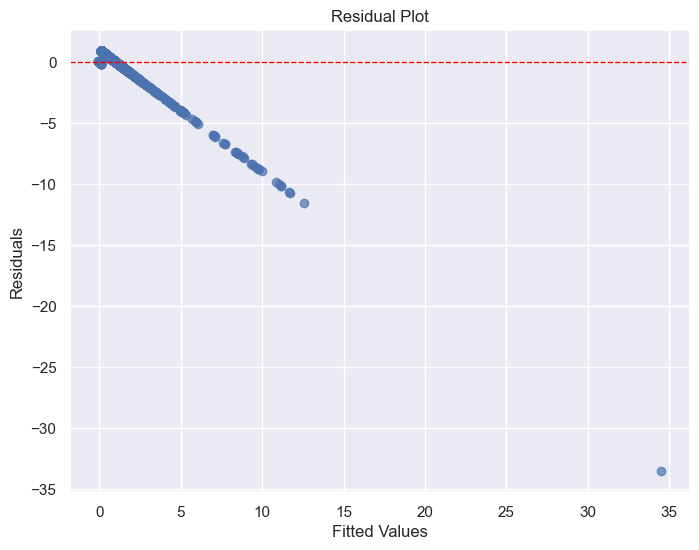

C:\Users\moata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


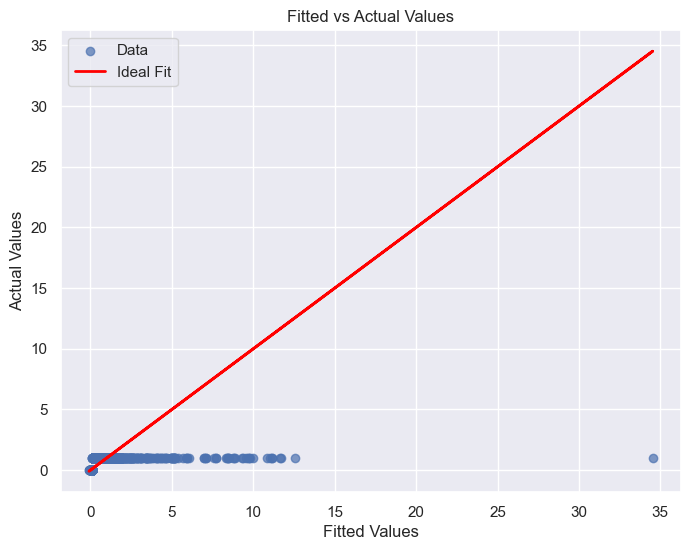

In [37]:
# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(model.fittedvalues, model.resid, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Fitted vs Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(model.fittedvalues, y, alpha=0.7, label='Data')
plt.plot(model.fittedvalues, model.fittedvalues, color='red', label='Ideal Fit', linewidth=2)
plt.title("Fitted vs Actual Values")
plt.xlabel("Fitted Values")
plt.ylabel("Actual Values")
plt.legend()
plt.grid(True)
plt.show()


why linear regression doesnt fit 

Residual Plot This plot depicts the residuals (differences between observed and predicted values) against the fitted values (predicted by the model).

Residuals should be randomly scattered around the horizontal line at 0 and not having a pattern but due to Patternsit Indicate non-linear relationships 

This compares the model's predictions (fitted values) to the actual observed values (y) shown nonlinear 



# Correlation Only for Numerical Columns 

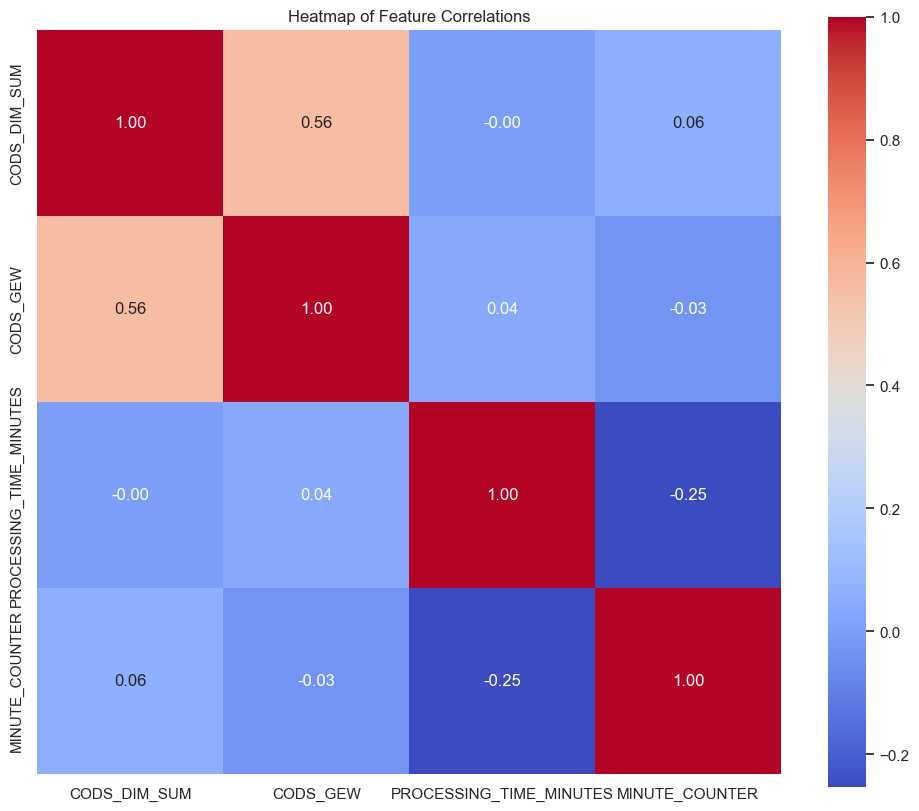

In [10]:
# Calculate correlation matrix for numeric columns
correlation_matrix = numeric_data.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap of Feature Correlations')
#print(correlation_matrix)
#display(correlation_matrix)
plt.show()


#### Key observations:

CODS_DIM1, CODS_DIM2, and CODS_DIM3 show strong correlations with one another. so i added them up and created a CODS_DIM_SUM to reduce the parameters 

CODS_GEW (weight) has a moderate correlation with CODS_DIM1, CODS_DIM2, and CODS_DIM3, indicating a relationship between weight and package dimensions.

PROCESSING_TIME_MINUTES shows a weak negative correlation with most variables,  suggesting it is not strongly influenced by these factors.

# scatter plots for numeric features with significant correlations pairs


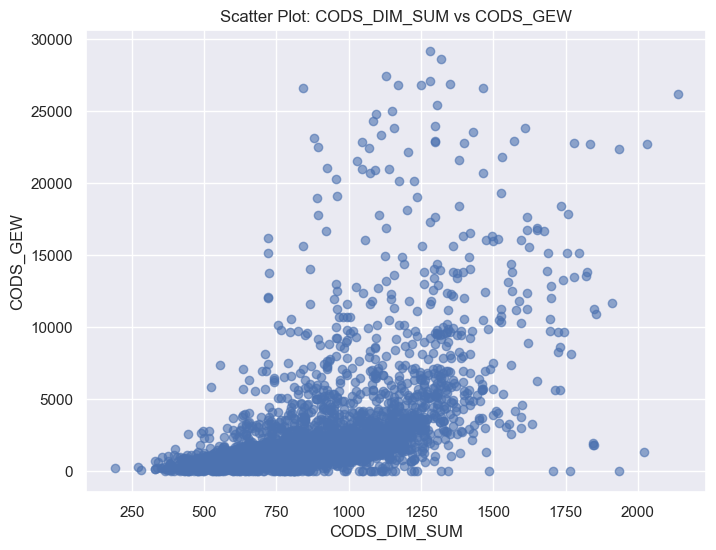

In [13]:
# Plot scatter plots for numeric features with significant correlations
significant_pairs = [
    ('CODS_DIM_SUM', 'CODS_GEW')
]

# Generate scatter plots for the selected feature pairs
for feature_x, feature_y in significant_pairs:
    plt.figure(figsize=(8, 6))
    plt.scatter(numeric_data[feature_x], numeric_data[feature_y], alpha=0.6)
    plt.title(f"Scatter Plot: {feature_x} vs {feature_y}")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.grid(True)
    plt.show()


# Generate histograms for all numeric features


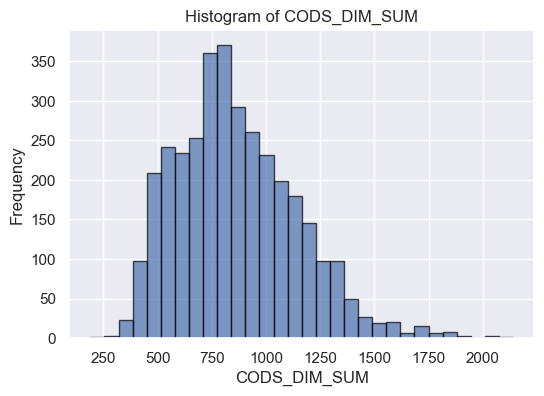

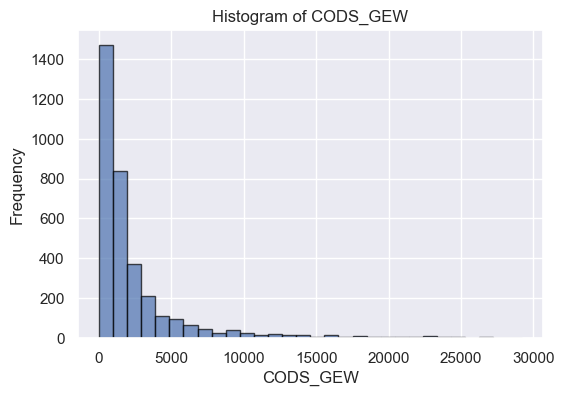

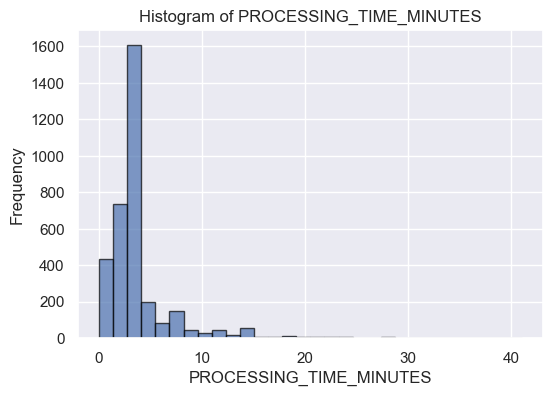

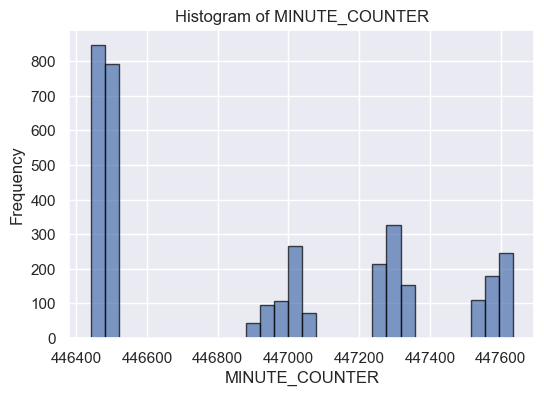

In [14]:
# Generate histograms for all numeric features
numeric_columns = numeric_data.columns

for column in numeric_columns:
    plt.figure(figsize=(6, 4))
    plt.hist(numeric_data[column], bins=30, alpha=0.7, edgecolor='black')
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


# mutual information correlation scores for the categorical features 

In [15]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Encode categorical data for mutual information calculation
encoded_data = data[categorical_features].apply(LabelEncoder().fit_transform)

# Calculate mutual information
mi_scores = {}
for cat_feature in categorical_features:
    mi_score = mutual_info_classif(
        encoded_data, data[cat_feature], discrete_features=True
    )
    mi_scores[cat_feature] = mi_score

# Convert mutual information scores to a DataFrame
mi_df = pd.DataFrame.from_dict(mi_scores, orient='index', columns=categorical_features)

# Display the mutual information scores
print("Mutual Information Correlation Scores")
print(mi_df)

Mutual Information Correlation Scores
                    CODS_ADR_PLZZZ_AN  CODS_CO_STATION  CODS_ZENT_NR  \
CODS_ADR_PLZZZ_AN            6.098306         1.627287           0.0   
CODS_CO_STATION              1.627287         3.314455           0.0   
CODS_ZENT_NR                 0.000000         0.000000           0.0   
CODS_SD_RUTSCHE              4.422671         1.077390           0.0   
DAY_15MIN                    1.524465         0.624350           0.0   
CODS_LERE_DAT                5.704246         2.997214           0.0   
SORTING_PERF_ISSUE           0.071530         0.013545           0.0   

                    CODS_SD_RUTSCHE  DAY_15MIN  CODS_LERE_DAT  \
CODS_ADR_PLZZZ_AN          4.422671   1.524465       5.704246   
CODS_CO_STATION            1.077390   0.624350       2.997214   
CODS_ZENT_NR               0.000000   0.000000       0.000000   
CODS_SD_RUTSCHE            5.430223   1.060537       5.038170   
DAY_15MIN                  1.060537   2.959777       2.95977

Mutual Information Scores :measures the dependency between two variables. It can capture complex, non-linear relationships.

It quantifies how much knowing the value of one variable reduces uncertainty about the other.

MI scores are non-negative (always ≥ 0). A score of 0 indicates no dependency between the variables.

Higher values indicate stronger relationships or dependency.

Interpretation: MI does not assume linear relationships (unlike correlation coefficients).


<span style="color: magenta; font-weight: bold;">CODS_ADR_PLZZZ_AN has a strong MI score with CODS_SD_RUTSCHE (4.42) and CODS_LERE_DAT (5.70), suggesting these features share significant information.</span>

<span style="color: magenta; font-weight: bold;">CODS_LERE_DAT shows high MI with CODS_ADR_PLZZZ_AN (5.70) and itself (7.75), likely indicating a dependency between time-based features.</span>

<span style="color: magenta; font-weight: bold;">SORTING_PERF_ISSUE, the target variable, shows relatively low MI with other features: </span>

Highest with CODS_LERE_DAT (0.1665), suggesting this feature might provide the most predictive power.

Lowest with features like CODS_CO_STATION (0.0135), indicating minimal dependency.

Zero Values: Scores like 0.0 (e.g., CODS_ZENT_NR with all others) imply no observed dependency between those features.


# Visualize the count distributions of some categorical feature


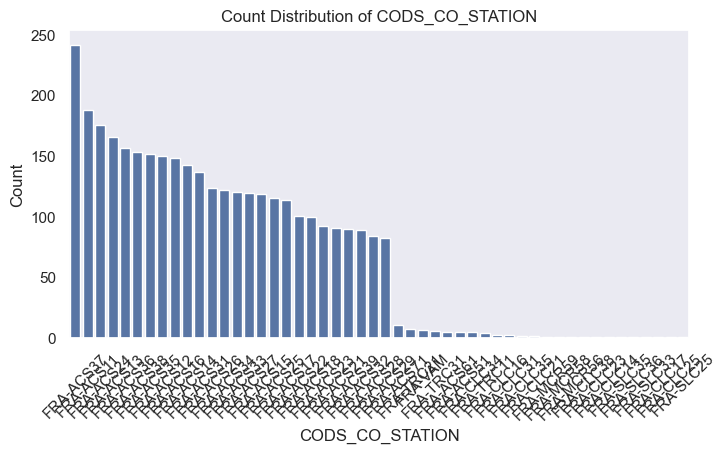

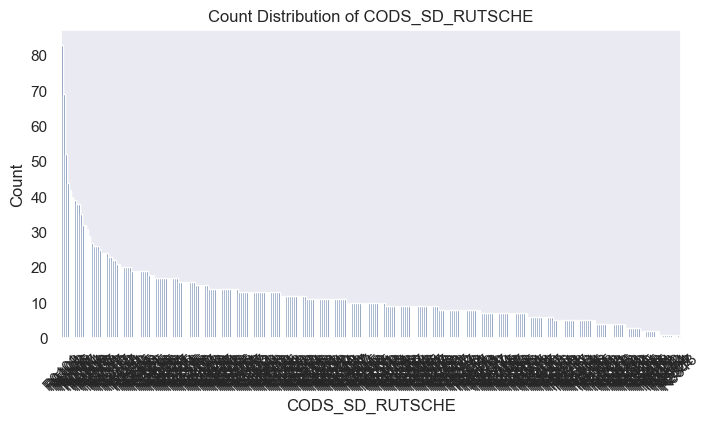

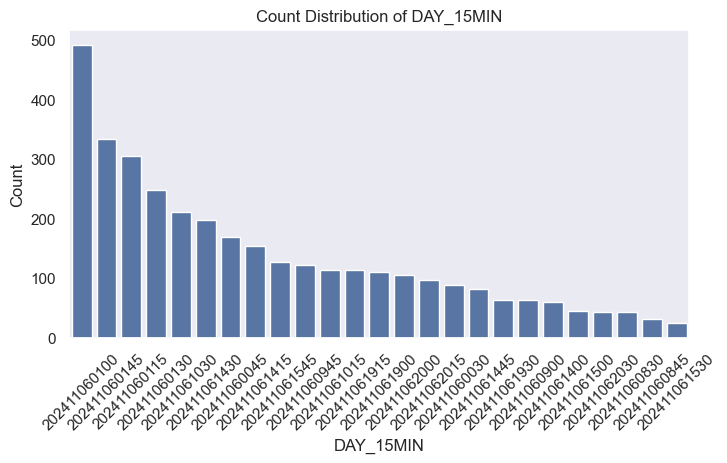

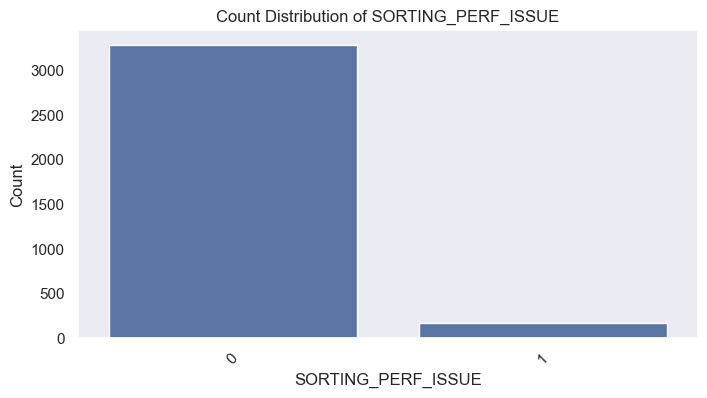

In [7]:
import seaborn as sns

for feature in ['CODS_CO_STATION', 'CODS_SD_RUTSCHE','DAY_15MIN','SORTING_PERF_ISSUE'] :
    plt.figure(figsize=(8, 4))
    sns.countplot(data=Categorical_data, x=feature, order=Categorical_data[feature].value_counts().index)
    plt.title(f"Count Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()


# Iterating Over Pairs of Categorical Features

This setup will loop through combinations of categorical features to perform Chi-Square or Fisher's Exact Test.

In [8]:
from itertools import combinations
from scipy.stats import chi2_contingency, fisher_exact

# categorical_features is list of features
for feature1, feature2 in combinations(categorical_features, 2):
    # Create a contingency table
    contingency_table = pd.crosstab(Categorical_data[feature1], Categorical_data[feature2])
    
    # Ensure it is not too small for chi-square test
    if contingency_table.shape == (2, 2):
        # Use Fisher's Exact Test for 2x2 tables
        odds_ratio, p_value = fisher_exact(contingency_table.values)
        print(f"Fisher's Test for {feature1} vs {feature2}: p-value = {p_value}")
    else:
        # Use Chi-Square Test for larger tables
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"Chi-Square Test for {feature1} vs {feature2}: p-value = {p}")
    
    # Interpret the results
    if p < 0.05:
        print(f"Significant association between {feature1} and {feature2}\n")
    else:
        print(f"No significant association between {feature1} and {feature2}\n")


Chi-Square Test for CODS_ADR_PLZZZ_AN vs CODS_CO_STATION: p-value = 1.0
No significant association between CODS_ADR_PLZZZ_AN and CODS_CO_STATION

Chi-Square Test for CODS_ADR_PLZZZ_AN vs CODS_ZENT_NR: p-value = 1.0
No significant association between CODS_ADR_PLZZZ_AN and CODS_ZENT_NR

Chi-Square Test for CODS_ADR_PLZZZ_AN vs CODS_SD_RUTSCHE: p-value = 0.0
Significant association between CODS_ADR_PLZZZ_AN and CODS_SD_RUTSCHE

Chi-Square Test for CODS_ADR_PLZZZ_AN vs DAY_15MIN: p-value = 1.4649445692685174e-254
Significant association between CODS_ADR_PLZZZ_AN and DAY_15MIN

Chi-Square Test for CODS_ADR_PLZZZ_AN vs CODS_LERE_DAT: p-value = 1.2603159154589732e-117
Significant association between CODS_ADR_PLZZZ_AN and CODS_LERE_DAT

Chi-Square Test for CODS_ADR_PLZZZ_AN vs SORTING_PERF_ISSUE: p-value = 0.9999713436589663
No significant association between CODS_ADR_PLZZZ_AN and SORTING_PERF_ISSUE

Chi-Square Test for CODS_CO_STATION vs CODS_ZENT_NR: p-value = 1.0
No significant association 

Hypotheses: Null Hypothesis (𝐻0): No association between the variables. Alternative Hypothesis (𝐻1): There is an association between the variables.

p-value:The probability of observing the data assuming the null hypothesis is true. Threshold (alpha): Typically 0.05. If the p-value ≤ 0.05, reject 

Summary of Results:

<span style="color: red; font-weight: bold;">Significant Association:</span>

CODS_ADR_PLZZZ_AN vs CODS_SD_RUTSCHE (p-value = 0.0).

The very low p-value suggests a strong relationship between these variables.

Interpretation: The category of CODS_ADR_PLZZZ_AN influences or is influenced by CODS_SD_RUTSCHE.

<span style="color: red; font-weight: bold;">Strong Association (Extremely Low p-value):</span>

DAY_15MIN vs SORTING_PERF_ISSUE (p-value = 3.87e-39).

Extremely low p-value indicates a highly significant relationship.

<span style="color: red; font-weight: bold;">Borderline Non-Significant:</span>

CODS_LERE_DAT vs SORTING_PERF_ISSUE (p-value = 0.08).

The p-value is close to the 0.05 threshold, suggesting weak evidence of association.

<span style="color: red; font-weight: bold;">No Significant Association:</span>

CODS_ADR_PLZZZ_AN vs CODS_CO_STATION (p-value = 1.0).

The high p-value indicates no association; changes in CODS_ADR_PLZZZ_AN are not related to changes in CODS_CO_STATION.


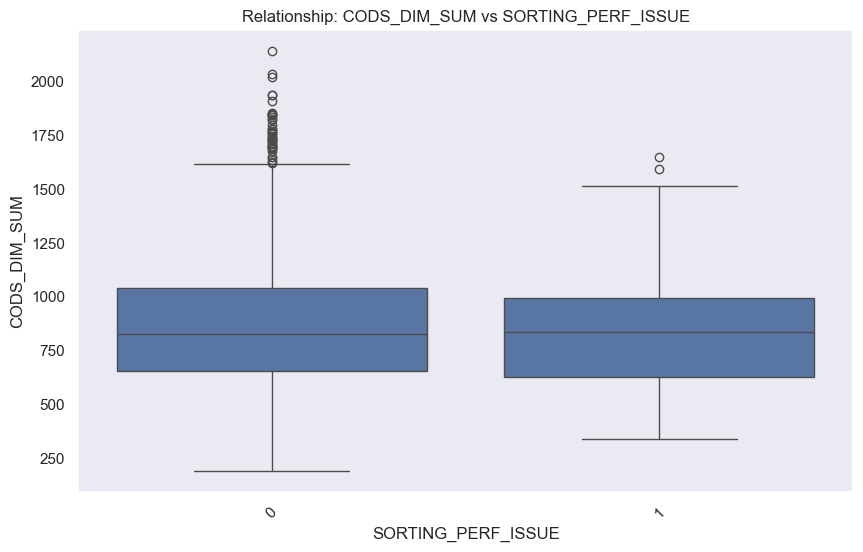

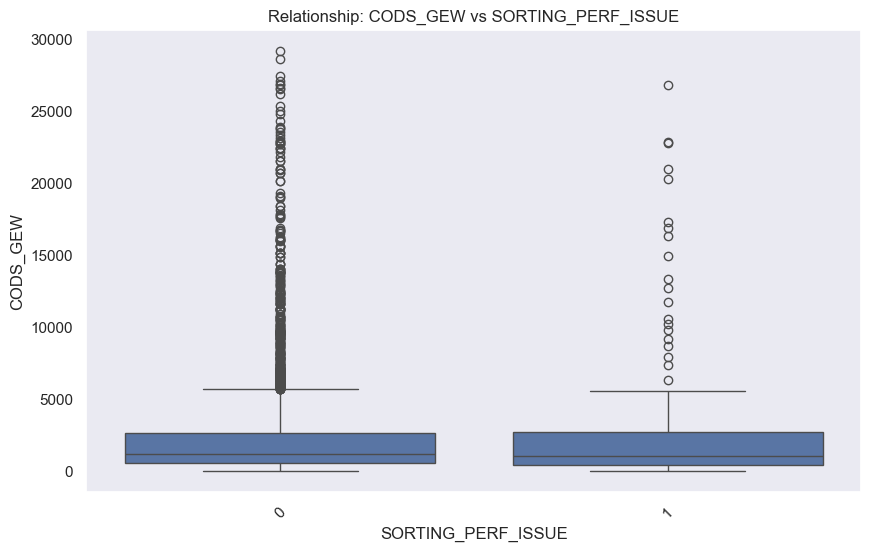

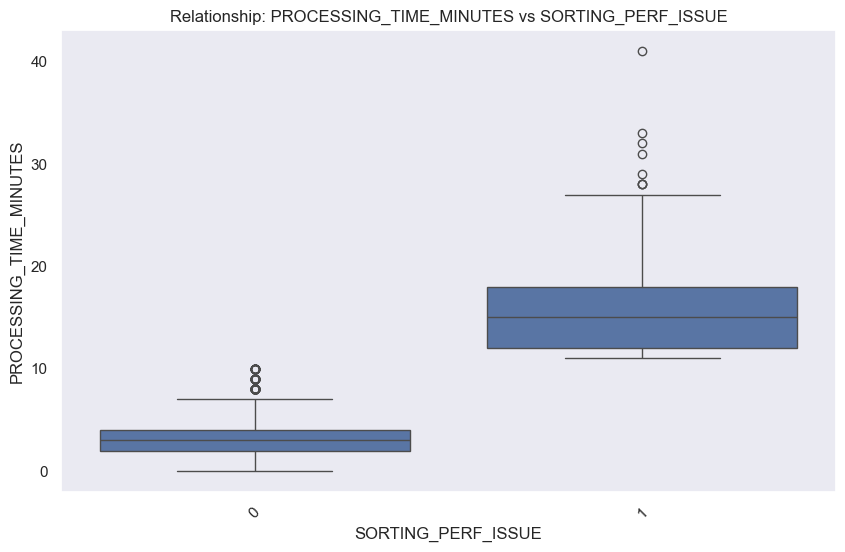

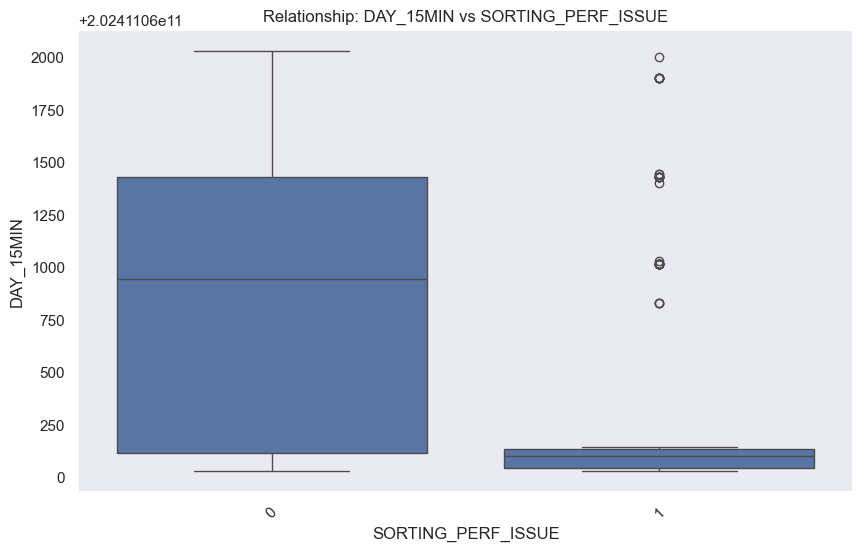

In [25]:
# Analyze relationships between numeric and categorical features using boxplots
for categorical_feature in ['SORTING_PERF_ISSUE']:
    for numeric_feature in ['CODS_DIM_SUM','CODS_GEW','PROCESSING_TIME_MINUTES','DAY_15MIN']:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=data, x=categorical_feature, y=numeric_feature)
        plt.title(f"Relationship: {numeric_feature} vs {categorical_feature}")
        plt.xlabel(categorical_feature)
        plt.ylabel(numeric_feature)
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.show()


# Analyze the effect of categories on processing times


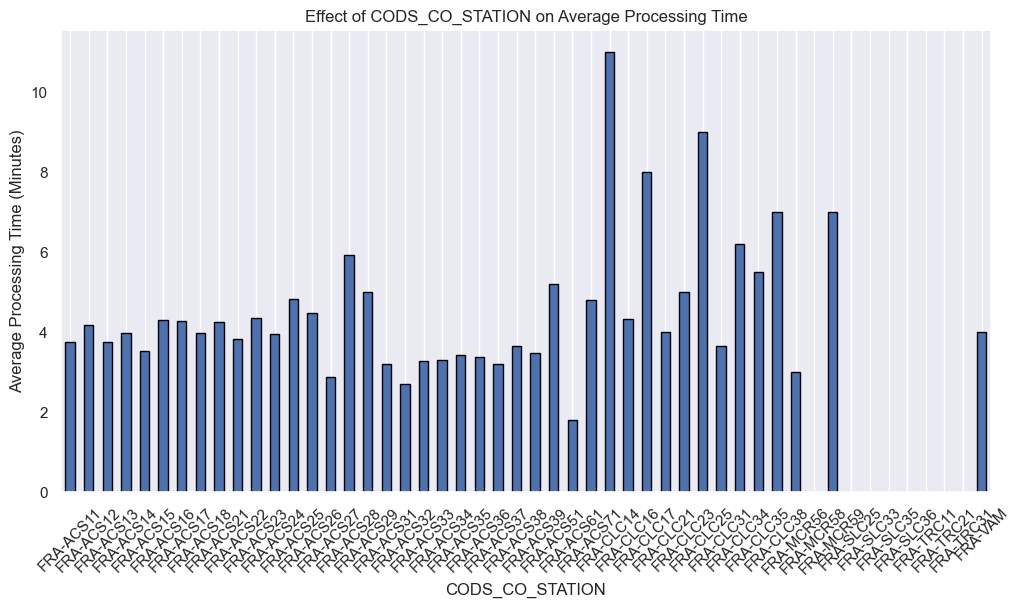

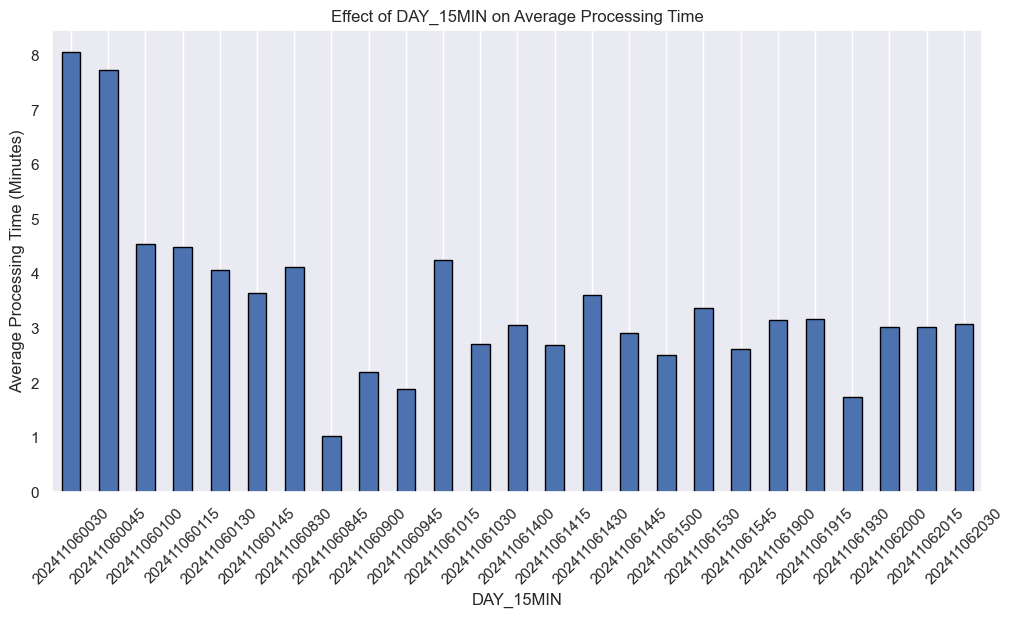

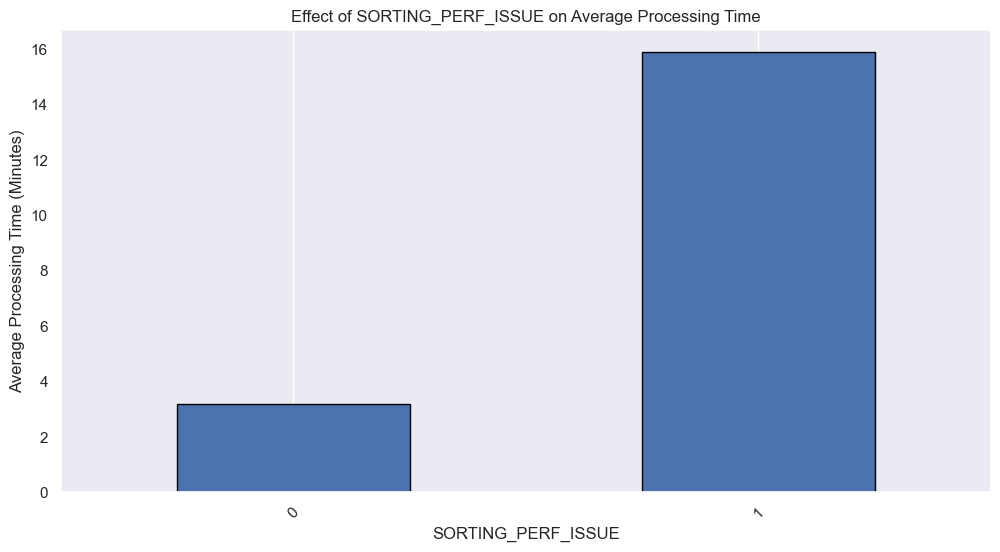

In [25]:
# Analyze the effect of categories on processing times

categorical_effect = {}
for feature in ['CODS_CO_STATION', 'DAY_15MIN','SORTING_PERF_ISSUE']:
    processing_time_by_category = data.groupby(feature)['PROCESSING_TIME_MINUTES'].mean()
    categorical_effect[feature] = processing_time_by_category

# Visualize the effect of each category on processing times
for feature, processing_time in categorical_effect.items():
    plt.figure(figsize=(12, 6))
    processing_time.plot(kind='bar', edgecolor='black')
    plt.title(f"Effect of {feature} on Average Processing Time")
    plt.xlabel(feature)
    plt.ylabel("Average Processing Time (Minutes)")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()


# logistic regression model to predict SORTING_PERF_ISSUE

C:\Users\moata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

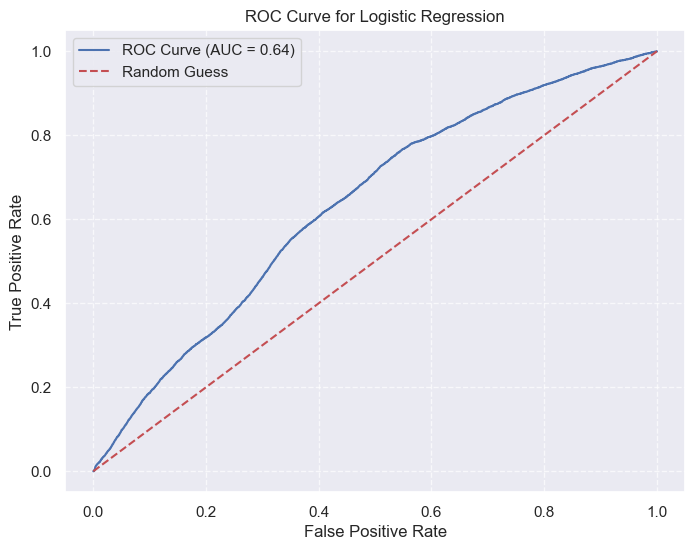

(0.9473563857729984,
 0.6351389042469926,
 {'0': {'precision': 0.9473563857729984,
   'recall': 1.0,
   'f1-score': 0.9729666256204537,
   'support': 153287.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8518.0},
  'accuracy': 0.9473563857729984,
  'macro avg': {'precision': 0.4736781928864992,
   'recall': 0.5,
   'f1-score': 0.48648331281022683,
   'support': 161805.0},
  'weighted avg': {'precision': 0.8974841216648781,
   'recall': 0.9473563857729984,
   'f1-score': 0.921746145925543,
   'support': 161805.0}})

In [38]:
# Define features and target for logistic regression
target = 'SORTING_PERF_ISSUE'
features = ['CODS_DIM_SUM','MINUTE_COUNTER']           
#            'CODS_ADR_PLZZZ_AN', 'CODS_CO_STATION', 'CODS_SD_RUTSCHE','DAY_15MIN']


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve



# Reload the data for classification
data_cleaned = data.drop(columns=['CODS_IDENTCODE_AN', 'CODS_LERE_DAT', 'DAY_15MIN'])

# Encoding categorical variables
categorical_columns = ['CODS_CO_STATION', 'CODS_SD_RUTSCHE']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col])
    label_encoders[col] = le

# Separating features and target
features = data_cleaned.drop(columns=['SORTING_PERF_ISSUE', 'PROCESSING_TIME_MINUTES'])
target_cls = data_cleaned['SORTING_PERF_ISSUE']

# Standardizing numeric features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    features_scaled, target_cls, test_size=0.2, random_state=42
)

# Retry logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_cls, y_train_cls)
y_pred_log = log_reg.predict(X_test_cls)
y_prob_log = log_reg.predict_proba(X_test_cls)[:, 1]

# Model Evaluation
accuracy = accuracy_score(y_test_cls, y_pred_log)
roc_auc = roc_auc_score(y_test_cls, y_prob_log)
classification_metrics_log = classification_report(y_test_cls, y_pred_log, output_dict=True)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_cls, y_prob_log)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.title("ROC Curve for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Display results
accuracy, roc_auc, classification_metrics_log


1. Overall Metrics: Precision for Class '0': 0.9474 (or 94.74%) Recall for Class '0': 1.0 (or 100%)

These values indicate that the model has high precision and perfect recall for class '0'.

2. Detailed Class-wise Metrics:

Class '0': Precision: 0.9474 Recall: 1.0 F1-Score: 0.9730 Support: 153,287

The model correctly identified all instances of class '0' (recall of 1.0) and had a high precision, indicating few false positives.

Class '1': Precision: 0.0 Recall: 0.0 F1-Score: 0.0 Support: 8,518

The model failed to identify any instances of class '1', resulting in zero precision, recall, and F1-score for this class.

3. Aggregate Metrics: Accuracy: 0.9474

This indicates that 94.74% of the total predictions were correct.

Interpretation:

The model performs exceptionally well for class '0', with high precision and perfect recall. However, it fails to identify any instances of class '1', 

as evidenced by the zero scores across all metrics for this class. This discrepancy suggests that the model may be biased towards the majority class (class '0'), potentially due to an 

<span style="color: red; font-weight: bold;">This discrepancy suggests that the model may be biased towards the majority class (class '0'), potentially due to an imbalanced dataset where class '0' significantly outnumbers class '1'. </span>

# Gaussian Mixture clustering with PCA reduction 

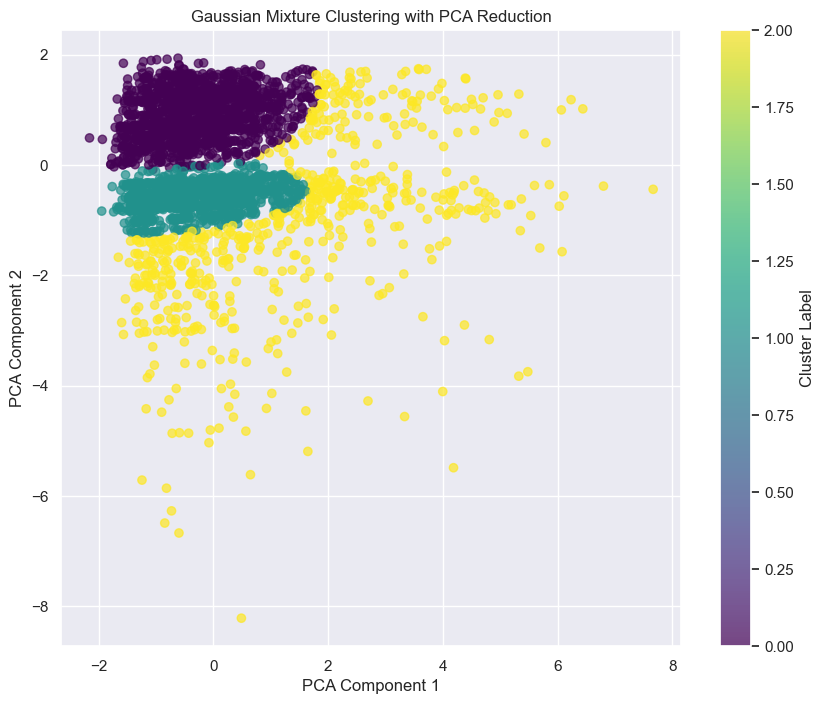

PCA Variance Explained and Clustering Labels


,PCA Component 1,PCA Component 2,Cluster Label
0,0.663388,0.865664,0
1,0.676593,0.661828,0
2,0.808639,0.171119,2
3,0.223232,-0.387858,1
4,-0.322311,-2.083079,2
...,...,...,...
3449,-1.504726,-0.380040,1
3450,-0.956668,-2.390292,2
3451,1.833803,-0.442775,2
3452,-0.692111,-0.517800,1


In [26]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Prepare the data: scale numeric features
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_data)

# Apply PCA to reduce dimensions
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(numeric_scaled)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)  # Assuming 3 clusters for now
gmm_labels = gmm.fit_predict(pca_result)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
plt.title("Gaussian Mixture Clustering with PCA Reduction")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.grid(True)
plt.show()

# Provide explained variance ratio for PCA components
pca_variance_ratio = pca.explained_variance_ratio_

# Display PCA and GMM cluster results

pca_gmm_df = pd.DataFrame({
    "PCA Component 1": pca_result[:, 0],
    "PCA Component 2": pca_result[:, 1],
    "Cluster Label": gmm_labels
})

print("PCA Variance Explained and Clustering Labels")
display(pca_gmm_df)



# t-sne

C:\Users\moata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


      t-SNE1     t-SNE2
0 -19.561937   1.658104
1 -19.896561   2.696772
2 -27.336050   7.869743
3 -14.234898  16.844345
4  -4.617468   3.347852


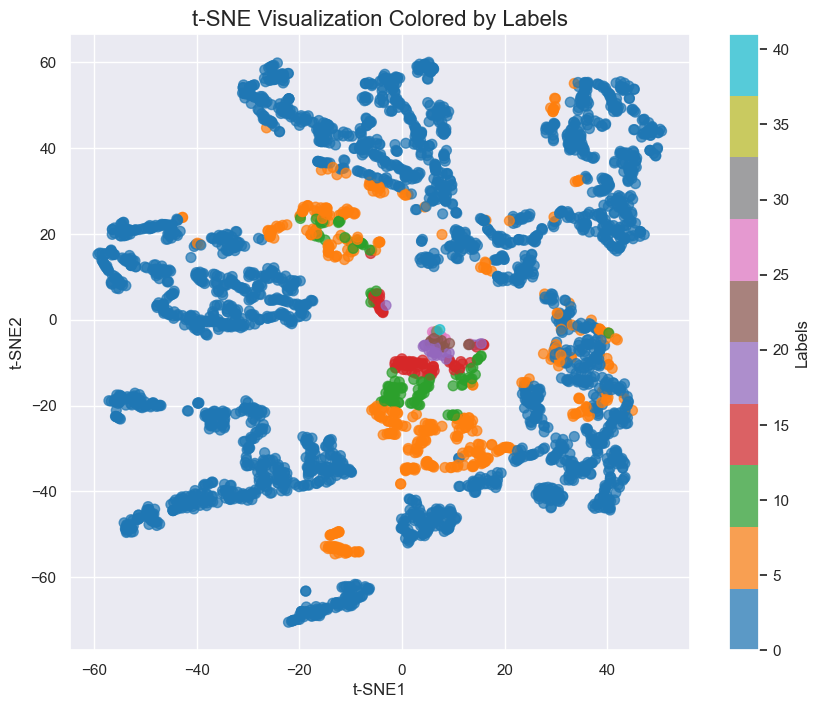

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Selecting numeric columns for t-SNE
numeric_columns = ['CODS_DIM_SUM', 'CODS_GEW', 
                   'MINUTE_COUNTER', 'PROCESSING_TIME_MINUTES']

# Preprocessing: Normalizing the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data[numeric_columns])

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(normalized_data)

# Creating a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['t-SNE1', 't-SNE2'])

# Display the t-SNE results to the user
print(tsne_df.head())

import matplotlib.pyplot as plt

labels = data['PROCESSING_TIME_MINUTES']  # Replace with your label column name

# Create a scatter plot with colors based on labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], 
                       c=labels, cmap='tab10', s=50, alpha=0.7)

# Add a color bar to show the label categories
cbar = plt.colorbar(scatter)
cbar.set_label('Labels')

# Add titles and axis labels
plt.title('t-SNE Visualization Colored by Labels', fontsize=16)
plt.xlabel('t-SNE1', fontsize=12)
plt.ylabel('t-SNE2', fontsize=12)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


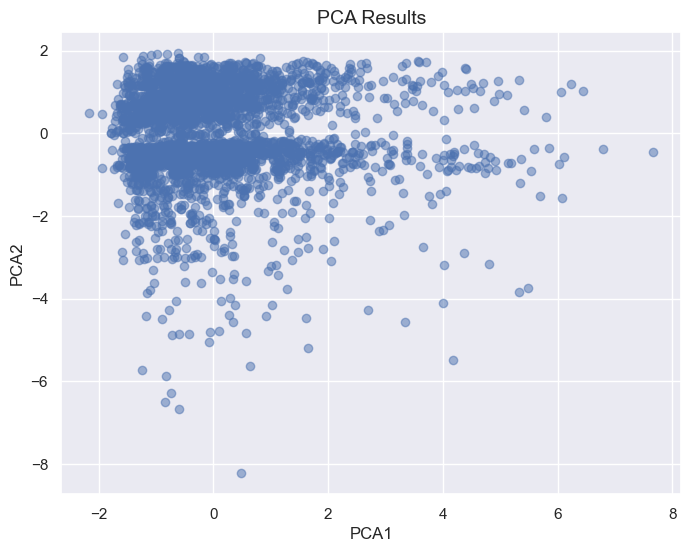

[0.39071552 0.31446503 0.18708452]


In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Selecting numeric columns for PCA
numeric_columns = ['CODS_DIM_SUM', 'CODS_GEW', 
                   'MINUTE_COUNTER', 'PROCESSING_TIME_MINUTES']

# Preprocessing: Normalizing the numeric data
scaler = StandardScaler()
normalized_data_new = scaler.fit_transform(data[numeric_columns])

# Applying PCA
pca = PCA(n_components=3)
pca_results = pca.fit_transform(normalized_data_new)

# Creating a DataFrame for PCA results
pca_df_new = pd.DataFrame(pca_results, columns=['PCA1', 'PCA2', 'PCA3'])

# Plotting the PCA results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pca_df_new['PCA1'], pca_df_new['PCA2'], alpha=0.5)
plt.title('PCA Results', fontsize=14)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.grid(True)
plt.show()

explained_variance = pca.explained_variance_ratio_
print(explained_variance)


The explained variance ratio for the first three principal components is:

PCA1: 39% of the variance
PCA2: 31% of the variance
PCA3: 18% of the variance

# Comparison of different Models Performance  

Model Performance Comparison:
                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.952243  0.745372
1        Random Forest  0.955137  0.811550
2                  SVC  0.756874  0.767892


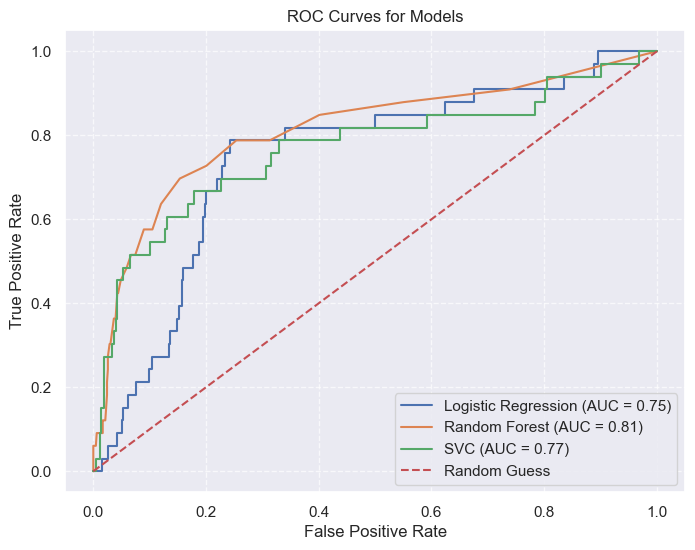

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# Data Preprocessing
# Drop unnecessary columns
data_cleaned = data.drop(columns=['CODS_IDENTCODE_AN', 'CODS_LERE_DAT', 'DAY_15MIN'])

# Encode categorical variables
categorical_columns = ['CODS_CO_STATION', 'CODS_SD_RUTSCHE']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col])
    label_encoders[col] = le

# Separate features and target
features = data_cleaned.drop(columns=['SORTING_PERF_ISSUE', 'PROCESSING_TIME_MINUTES'])
target_cls = data_cleaned['SORTING_PERF_ISSUE']

# Standardize numeric features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into training and testing sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    features_scaled, target_cls, test_size=0.2, random_state=42
)

# Logistic Regression Model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_cls, y_train_cls)
y_pred_log = log_reg.predict(X_test_cls)
y_prob_log = log_reg.predict_proba(X_test_cls)[:, 1]
accuracy_log = accuracy_score(y_test_cls, y_pred_log)
roc_auc_log = roc_auc_score(y_test_cls, y_prob_log)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_clf.fit(X_train_cls, y_train_cls)
y_pred_rf = rf_clf.predict(X_test_cls)
y_prob_rf = rf_clf.predict_proba(X_test_cls)[:, 1]
accuracy_rf = accuracy_score(y_test_cls, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_cls, y_prob_rf)

# Support Vector Classifier with RBF kernel
svc_clf = SVC(probability=True, random_state=42, class_weight='balanced')
svc_clf.fit(X_train_cls, y_train_cls)
y_pred_svc = svc_clf.predict(X_test_cls)
y_prob_svc = svc_clf.predict_proba(X_test_cls)[:, 1]
accuracy_svc = accuracy_score(y_test_cls, y_pred_svc)
roc_auc_svc = roc_auc_score(y_test_cls, y_prob_svc)

# Consolidate results for comparison
model_comparison = {
    "Model": ["Logistic Regression", "Random Forest", "SVC"],
    "Accuracy": [accuracy_log, accuracy_rf, accuracy_svc],
    "ROC-AUC": [roc_auc_log, roc_auc_rf, roc_auc_svc]
}

comparison_df = pd.DataFrame(model_comparison)
print("Model Performance Comparison:")
print(comparison_df)

# ROC Curve for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test_cls, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test_cls, y_prob_rf)
fpr_svc, tpr_svc, _ = roc_curve(y_test_cls, y_prob_svc)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_svc, tpr_svc, label=f"SVC (AUC = {roc_auc_svc:.2f})")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.title("ROC Curves for Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Logistic Regression: Accuracy: 95.22% ROC-AUC: 0.745 

This model demonstrates high accuracy, correctly predicting approximately 95% of instances. However, the ROC-AUC score of 0.745 suggests moderate ability in distinguishing between classes.

Random Forest: Accuracy: 95.51% ROC-AUC: 0.812

The Random Forest model achieves the highest accuracy among the three, at 95.51%. Its ROC-AUC score of 0.812 indicates a strong capability to differentiate between classes.

Support Vector Classifier (SVC): Accuracy: 75.69% ROC-AUC: 0.768

The SVC model has a lower accuracy of 75.69%, indicating it correctly predicts about 76% of instances. Despite this, its ROC-AUC score of 0.768 reflects a reasonable ability to distinguish between classes.

Accuracy measures the proportion of correct predictions out of all predictions made. While it's a straightforward metric, it can be misleading in cases of class imbalance.

ROC-AUC (Receiver Operating Characteristic - Area Under Curve) evaluates the model's ability to distinguish between classes across all threshold values. A higher ROC-AUC indicates better performance in differentiating between positive and negative classes.

Key Observations:

<span style="color: red; font-weight: bold;">Random Forest outperforms the other models in both accuracy and ROC-AUC, suggesting it is the most effective model for this dataset.</span>

Logistic Regression maintains high accuracy but has a lower ROC-AUC compared to Random Forest, indicating it may not be as proficient in distinguishing between classes.

SVC exhibits the lowest accuracy but a moderate ROC-AUC, implying that while it may not predict as many instances correctly overall, it has a reasonable ability to differentiate between classes.

# ConfusionMatrixDisplay

Confusion Matrix - Logistic Regression:
[[658   0]
 [ 33   0]]

Confusion Matrix - Random Forest:
[[658   0]
 [ 32   1]]

Confusion Matrix - SVC:
[[451 207]
 [  7  26]]


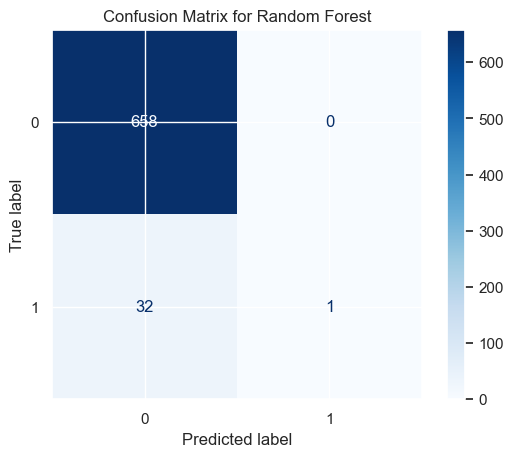

array([[658,   0],
       [ 32,   1]], dtype=int64)

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrices for each model
conf_matrix_log = confusion_matrix(y_test_cls, log_reg.predict(X_test_cls))
conf_matrix_rf = confusion_matrix(y_test_cls, y_pred_rf)
conf_matrix_svc = confusion_matrix(y_test_cls, y_pred_svc)

# Print the confusion matrices
print("Confusion Matrix - Logistic Regression:")
print(conf_matrix_log)
print("\nConfusion Matrix - Random Forest:")
print(conf_matrix_rf)
print("\nConfusion Matrix - SVC:")
print(conf_matrix_svc)


# Plot the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=rf_clf.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Return the raw confusion matrix
conf_matrix_rf




Logistic Regression: High accuracy in predicting the negative class but failed to detect any positive instances.

True Positives (TP): 0 False Positives (FP): 0 True Negatives (TN): 658False Negatives (FN): 33

The model correctly identified all 658 negative instances but failed to detect any of the 33 positive instances, resulting in zero true positives. This indicates a bias towards predicting the negative class.

Random Forest: Slight improvement over Logistic Regression with the detection of one positive instance.

TP: 1 FP: 0 TN: 658 FN: 32

Similar to Logistic Regression, the Random Forest model accurately classified all negative instances. However, it managed to identify 1 out of 33 positive instances, showing a slight improvement in detecting the positive class.

Support Vector Classifier (SVC): The SVC model identified 26 out of 33 positive instances, indicating a better sensitivity to the positive class compared to the other models. However, it also misclassified 207 negative instances as positive, leading to a higher false positive rate.

TP: 26 FP: 207 TN: 451 FN: 7

SVC: Better detection of positive instances but at the cost of a higher false positive rate.

Recommendations:

The performance of these models suggests a class imbalance, where the negative class significantly outnumbers the positive class. To address this:

By addressing the class imbalance and employing appropriate evaluation metrics, you can develop a more robust model that performs well across all classes.

# Analyze feature importance and Run KMeans 


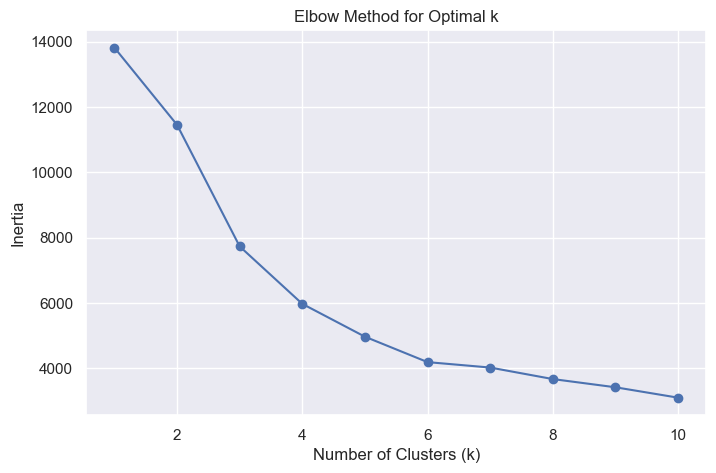

[13816.000000000007, 11452.94023951525, 7731.154762402024, 5972.078817581633, 4966.676391714753, 4188.488057523578, 4022.2613798047364, 3669.628317425183, 3418.1994747404406, 3100.0049809952025]


In [21]:
# Compute inertia for a range of cluster counts

inertia_values = []

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

print(inertia_values)

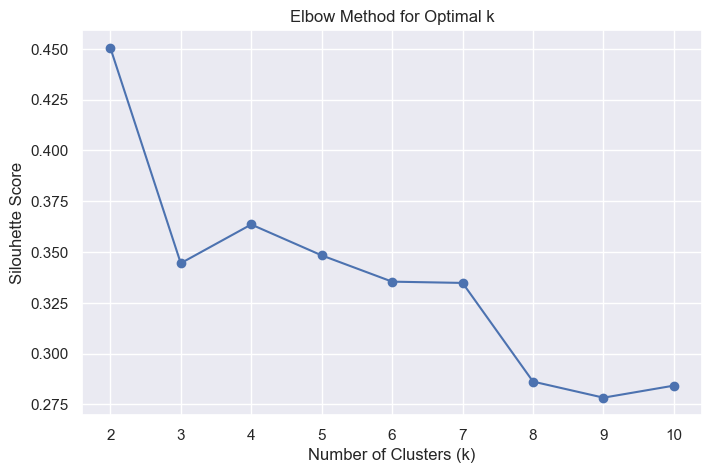

In [22]:
silhouette_values = []

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, cluster_labels)
    silhouette_values.append(score)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_values, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silouhette Score")
plt.grid(True)
plt.show()

#### Optimal number of clusters seems to be 4 or 5 with the combined methods of the inertia elbow method and silhoutte score peak.
We dedided to go with 5 clusters as we figured that this gives us the better results as you can see visually in the UMAP below

# UMAP with Kmeans Cluser

C:\Users\moata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


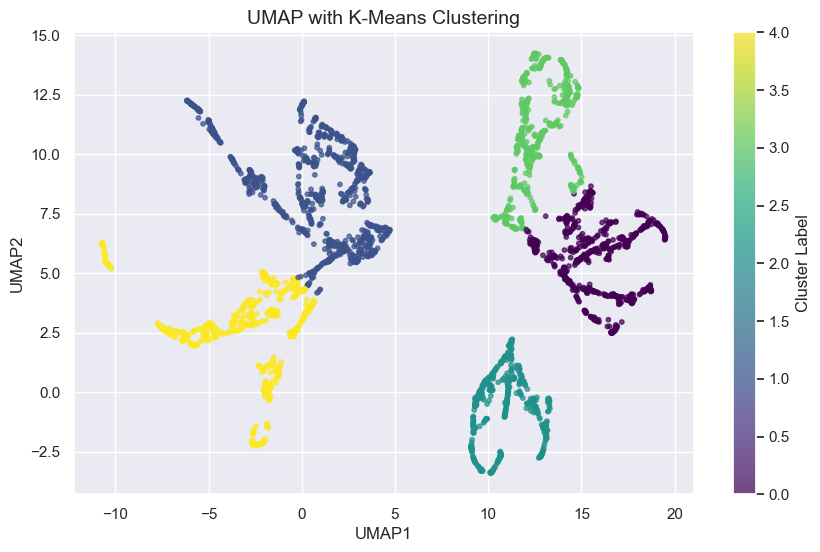

In [25]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Perform UMAP
umap = UMAP(n_components=2, random_state=42)
umap_results = umap.fit_transform(scaled_data)

# Create a DataFrame for UMAP results
umap_df = pd.DataFrame(umap_results, columns=["UMAP1", "UMAP2"])

# Perform K-Means Clustering on UMAP results
n_clusters = 5  # Set the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(umap_results)

# Add cluster labels to the UMAP DataFrame
umap_df['Cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=umap_df['Cluster'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")
plt.title("UMAP with K-Means Clustering", fontsize=14)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.show()

# Optionally, save the clustered UMAP results to a CSV file
umap_df.to_csv('umap_clustered_results.csv', index=False)

# Hierarchical Clustering Dendrogram

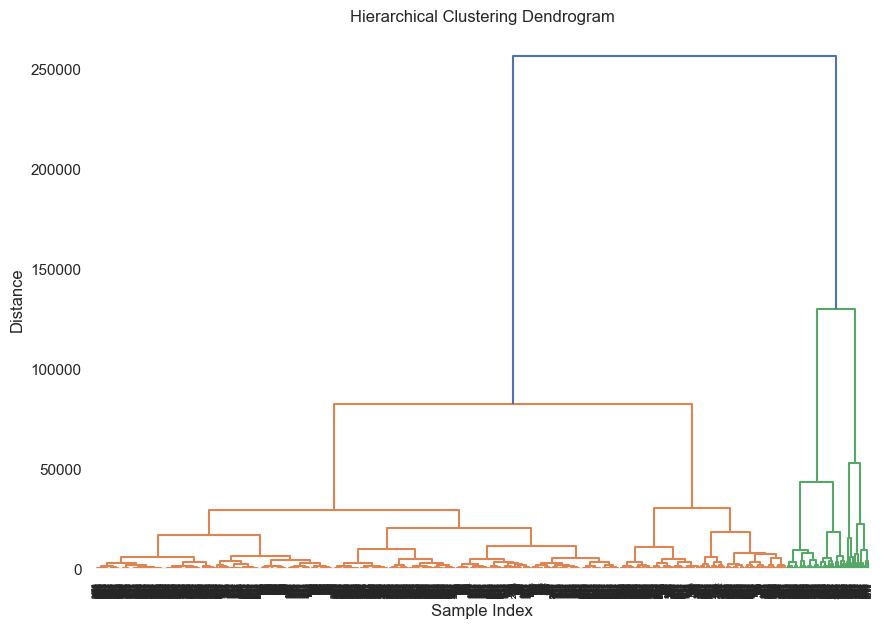

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Compute the linkage matrix
linkage_matrix = linkage(numeric_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# HDBSCAN 

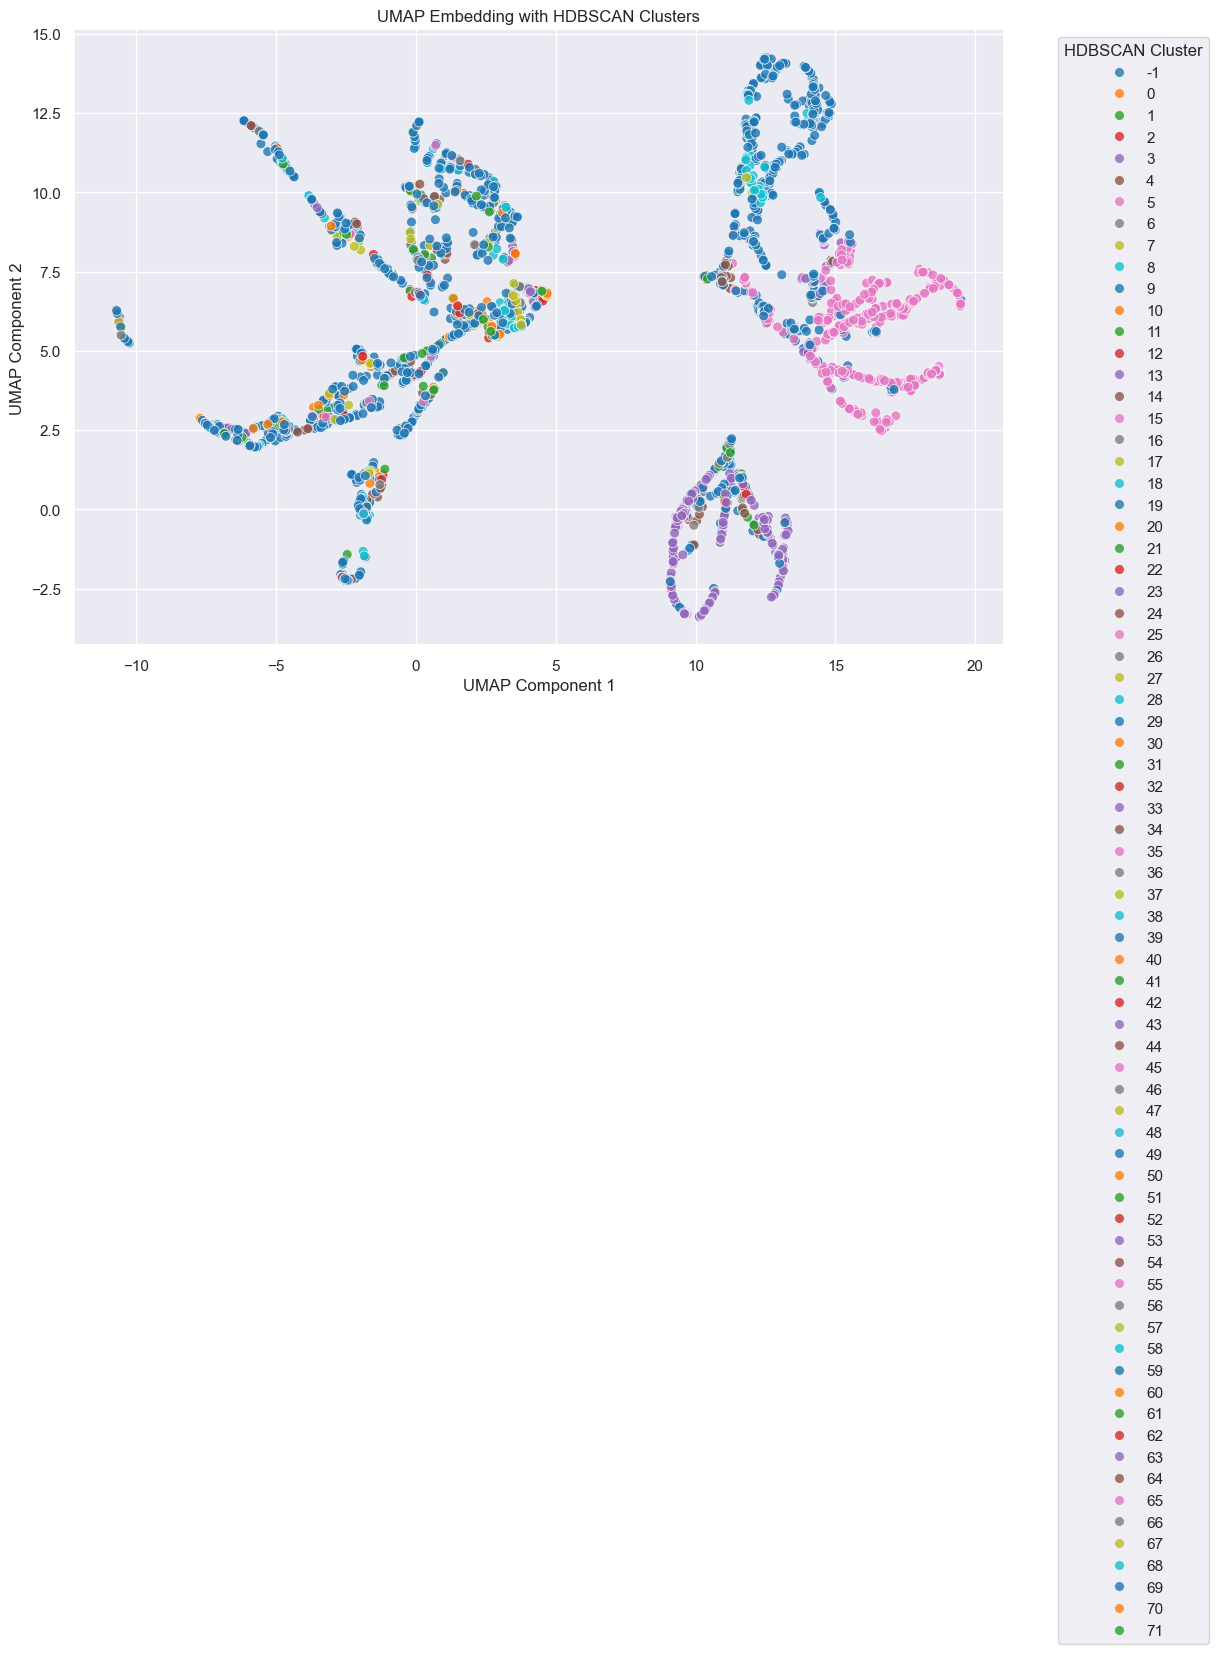

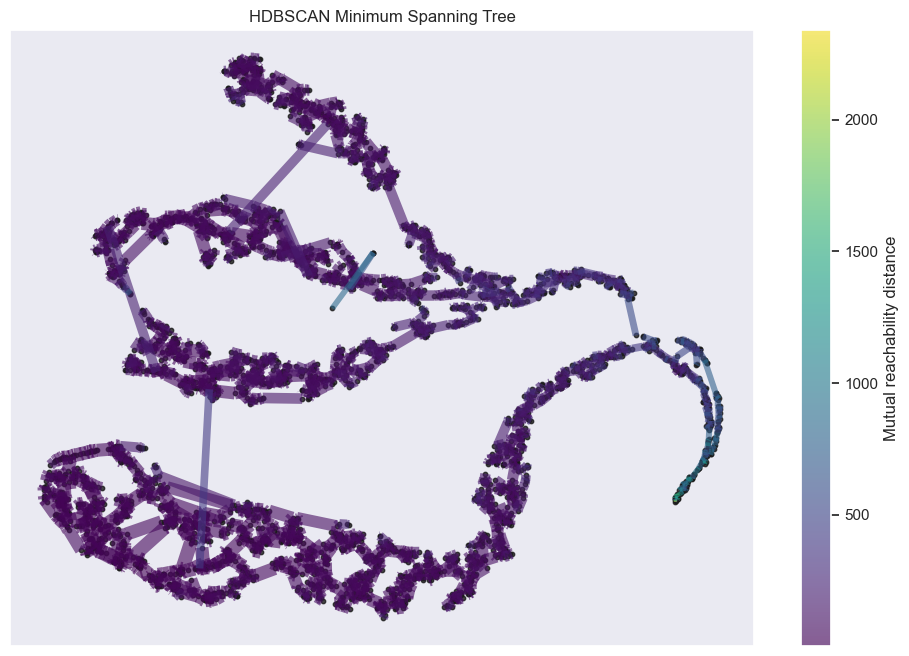

In [ ]:
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

# Applying HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, gen_min_span_tree=True)
hdbscan_labels = hdbscan_clusterer.fit_predict(numeric_data)

# Add the HDBSCAN cluster labels to the dataset
umap_df['hdbscan_cluster'] = hdbscan_labels

# Plot HDBSCAN clusters on UMAP embedding
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='hdbscan_cluster',
    data=umap_df,
    palette='tab10',
    alpha=0.8,
    s=50
)
plt.title('UMAP Embedding with HDBSCAN Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='HDBSCAN Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Optional: Plot the minimum spanning tree
plt.figure(figsize=(12, 8))
hdbscan_clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=10)
plt.title('HDBSCAN Minimum Spanning Tree')
plt.show()



# BoxPlot the Clusters 

Analyzing features: ['CODS_DIM_SUM', 'CODS_GEW', 'MINUTE_COUNTER', 'PROCESSING_TIME_MINUTES']


C:\Users\moata\AppData\Local\Temp\ipykernel_12084\3088699516.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=feature, data=data, palette="viridis")


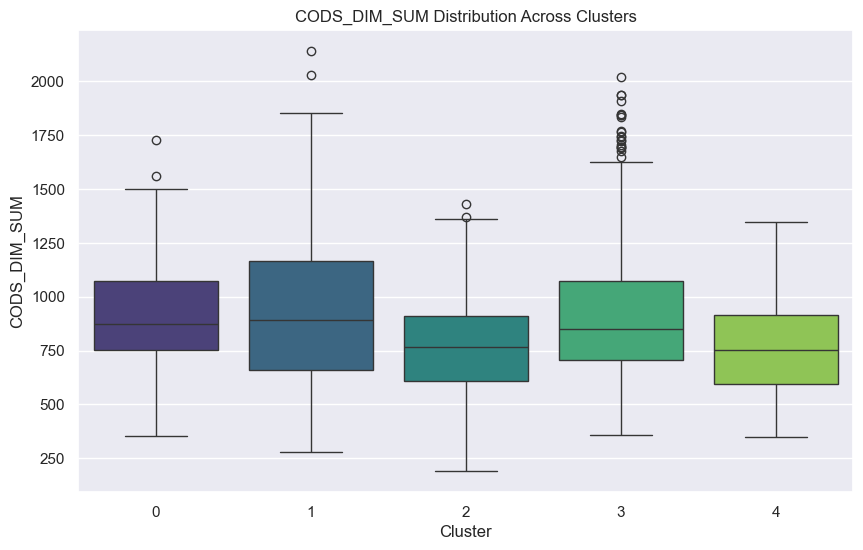


Summary statistics for CODS_DIM_SUM by cluster:
          count        mean         std    min    25%    50%     75%     max
Cluster                                                                    
0        707.0  904.364922  238.790578  355.0  755.0  875.0  1073.5  1730.0
1        941.0  922.826780  325.622116  280.0  660.0  890.0  1165.0  2140.0
2        519.0  772.616570  224.039773  190.0  610.0  765.0   911.5  1430.0
3        583.0  909.394511  307.399516  360.0  705.0  850.0  1075.0  2020.0
4        704.0  763.649148  205.687476  350.0  595.0  755.0   915.0  1345.0


C:\Users\moata\AppData\Local\Temp\ipykernel_12084\3088699516.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=feature, data=data, palette="viridis")


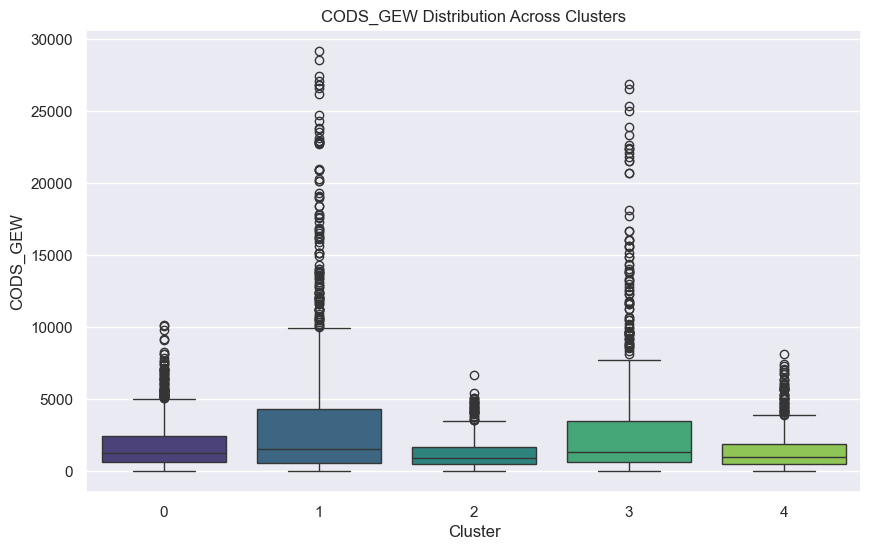


Summary statistics for CODS_GEW by cluster:
          count         mean          std  min    25%     50%     75%      max
Cluster                                                                      
0        707.0  1895.190948  1873.340493  0.0  660.0  1260.0  2430.0  10160.0
1        941.0  3793.942614  5307.103657  0.0  600.0  1520.0  4340.0  29180.0
2        519.0  1286.319846  1169.507099  0.0  480.0   900.0  1690.0   6660.0
3        583.0  3403.533448  4961.562136  0.0  660.0  1340.0  3510.0  26920.0
4        704.0  1468.323864  1427.950825  0.0  500.0  1000.0  1860.0   8160.0


C:\Users\moata\AppData\Local\Temp\ipykernel_12084\3088699516.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=feature, data=data, palette="viridis")


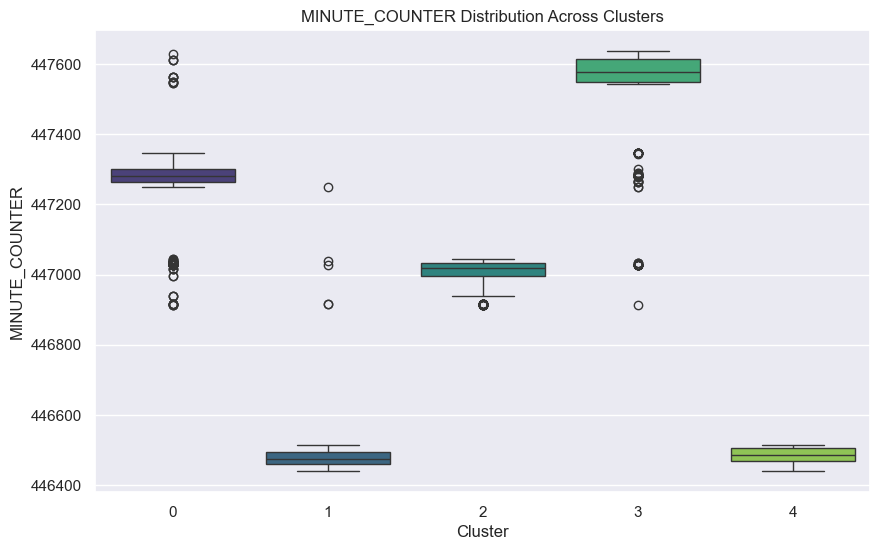


Summary statistics for MINUTE_COUNTER by cluster:
          count           mean         std       min       25%       50%  \
Cluster                                                                   
0        707.0  447277.230552   88.214821  446914.0  447265.0  447282.0   
1        941.0  446479.769394   46.213300  446440.0  446461.0  446475.0   
2        519.0  447000.614644   40.971337  446914.0  446995.0  447018.0   
3        583.0  447550.710120  121.296405  446914.0  447548.0  447576.0   
4        704.0  446486.454545   20.355886  446440.0  446470.0  446487.0   

              75%       max  
Cluster                      
0        447302.0  447627.0  
1        446496.0  447249.0  
2        447034.0  447043.0  
3        447614.0  447636.0  
4        446506.0  446514.0  


C:\Users\moata\AppData\Local\Temp\ipykernel_12084\3088699516.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=feature, data=data, palette="viridis")


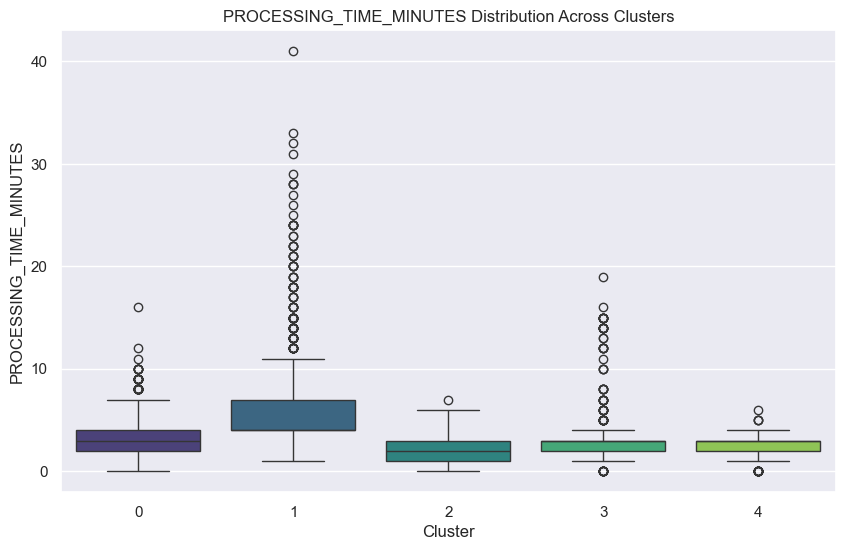


Summary statistics for PROCESSING_TIME_MINUTES by cluster:
          count      mean       std  min  25%  50%  75%   max
Cluster                                                     
0        707.0  3.220651  2.137477  0.0  2.0  3.0  4.0  16.0
1        941.0  6.471838  4.946147  1.0  4.0  4.0  7.0  41.0
2        519.0  2.127168  1.147102  0.0  1.0  2.0  3.0   7.0
3        583.0  3.138937  2.741355  0.0  2.0  3.0  3.0  19.0
4        704.0  2.620739  0.703312  0.0  2.0  3.0  3.0   6.0


In [26]:
umap_df = pd.read_csv('umap_clustered_results.csv')  # UMAP results with clusters

# Merge UMAP clusters with original data for analysis
clustered_data = pd.concat([data, umap_df[['Cluster']]], axis=1)

# Analyze feature distributions for each cluster
def analyze_clusters(data, cluster_col='Cluster', features=None):
    """
    Analyzes the distribution of features across clusters.

    Parameters:
    - data: DataFrame containing the original features and cluster labels.
    - cluster_col: Column name containing cluster labels.
    - features: List of features to analyze. If None, analyze all numerical features.

    Returns:
    - None. Displays visualizations and prints summary statistics.
    """
    features = features or data.select_dtypes(include=['number']).columns.tolist()
    features.remove(cluster_col) if cluster_col in features else None

    print(f"Analyzing features: {features}")
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=cluster_col, y=feature, data=data, palette="viridis")
        plt.title(f"{feature} Distribution Across Clusters")
        plt.xlabel("Cluster")
        plt.ylabel(feature)
        plt.show()

        # Display summary statistics
        summary = data.groupby(cluster_col)[feature].describe()
        print(f"\nSummary statistics for {feature} by cluster:\n", summary)

# Features to analyze (optional: adjust based on your dataset)
features_to_analyze = ['CODS_DIM_SUM', 'CODS_GEW',
                  'MINUTE_COUNTER', 'PROCESSING_TIME_MINUTES']

# Run the cluster analysis
analyze_clusters(clustered_data, cluster_col='Cluster', features=features_to_analyze)

# Optional: Save analyzed data to CSV
clustered_data.to_csv('analyzed_clustered_data.csv', index=False)


Interstingly especially the "Minute Counter"-Dimension created the most distinct clusters, which might very well indicate that the time of day when a package arrives might have an impact. But how exactly is not yet clear

# Validates the quality of clusters using various metrics

Cluster Validation Metrics:
Silhouette Score: -0.02
Calinski-Harabasz Score: 0.16
Davies-Bouldin Score: 535.37


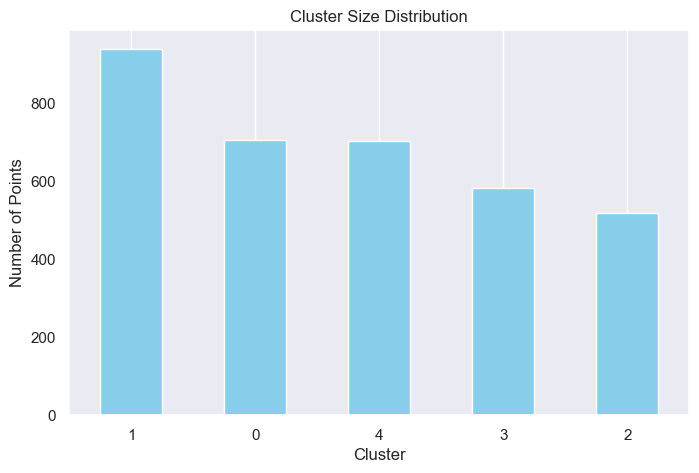

In [29]:
# Validate Clusters
def validate_clusters(data, cluster_col='Cluster', features=None):
    """
    Validates the quality of clusters using various metrics.

    Parameters:
    - data: DataFrame containing features and cluster labels.
    - cluster_col: Column name containing cluster labels.
    - features: List of features to use for validation. If None, use all numerical features.

    Returns:
    - A dictionary of cluster validation metrics.
    """
    # Extract feature columns and cluster labels
    features = features or data.select_dtypes(include=['number']).columns.tolist()
    if cluster_col in features:
        features.remove(cluster_col)
    feature_data = data[features]
    cluster_labels = data[cluster_col]

    # Calculate validation metrics
    metrics = {}

    # Silhouette Score (range: -1 to 1, higher is better)
    metrics['Silhouette Score'] = silhouette_score(feature_data, cluster_labels)

    # Calinski-Harabasz Index (higher is better)
    metrics['Calinski-Harabasz Score'] = calinski_harabasz_score(feature_data, cluster_labels)

    # Davies-Bouldin Index (lower is better)
    metrics['Davies-Bouldin Score'] = davies_bouldin_score(feature_data, cluster_labels)

    return metrics

# Plot Cluster Size Distribution
def plot_cluster_sizes(data, cluster_col='Cluster'):
    """
    Plots the distribution of data points across clusters.
    """
    cluster_counts = data[cluster_col].value_counts()
    plt.figure(figsize=(8, 5))
    cluster_counts.plot(kind='bar', color='skyblue')
    plt.title("Cluster Size Distribution")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Points")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

# Load the clustered dataset
data = pd.read_csv('analyzed_clustered_data.csv')  # Replace with your dataset
cluster_col = 'Cluster'

# Validate clusters
metrics = validate_clusters(data, cluster_col=cluster_col)
print("Cluster Validation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Visualize cluster sizes
plot_cluster_sizes(data, cluster_col=cluster_col)

Overall the Cluster Validation Metrics are rather weak:
1. Since the Silhouette Score ranges from -1 to 1, with one being the best, this just tells us that it is not very good. Might have a lot of noise in the data.
2. Again a low score indication that the clusters are not so well defined
3. A high score indicates the same thing as for the Calinski-Harabasz Score

# Random Forest and feature importance 

Accuracy Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       658
           1       1.00      1.00      1.00        33

    accuracy                           1.00       691
   macro avg       1.00      1.00      1.00       691
weighted avg       1.00      1.00      1.00       691



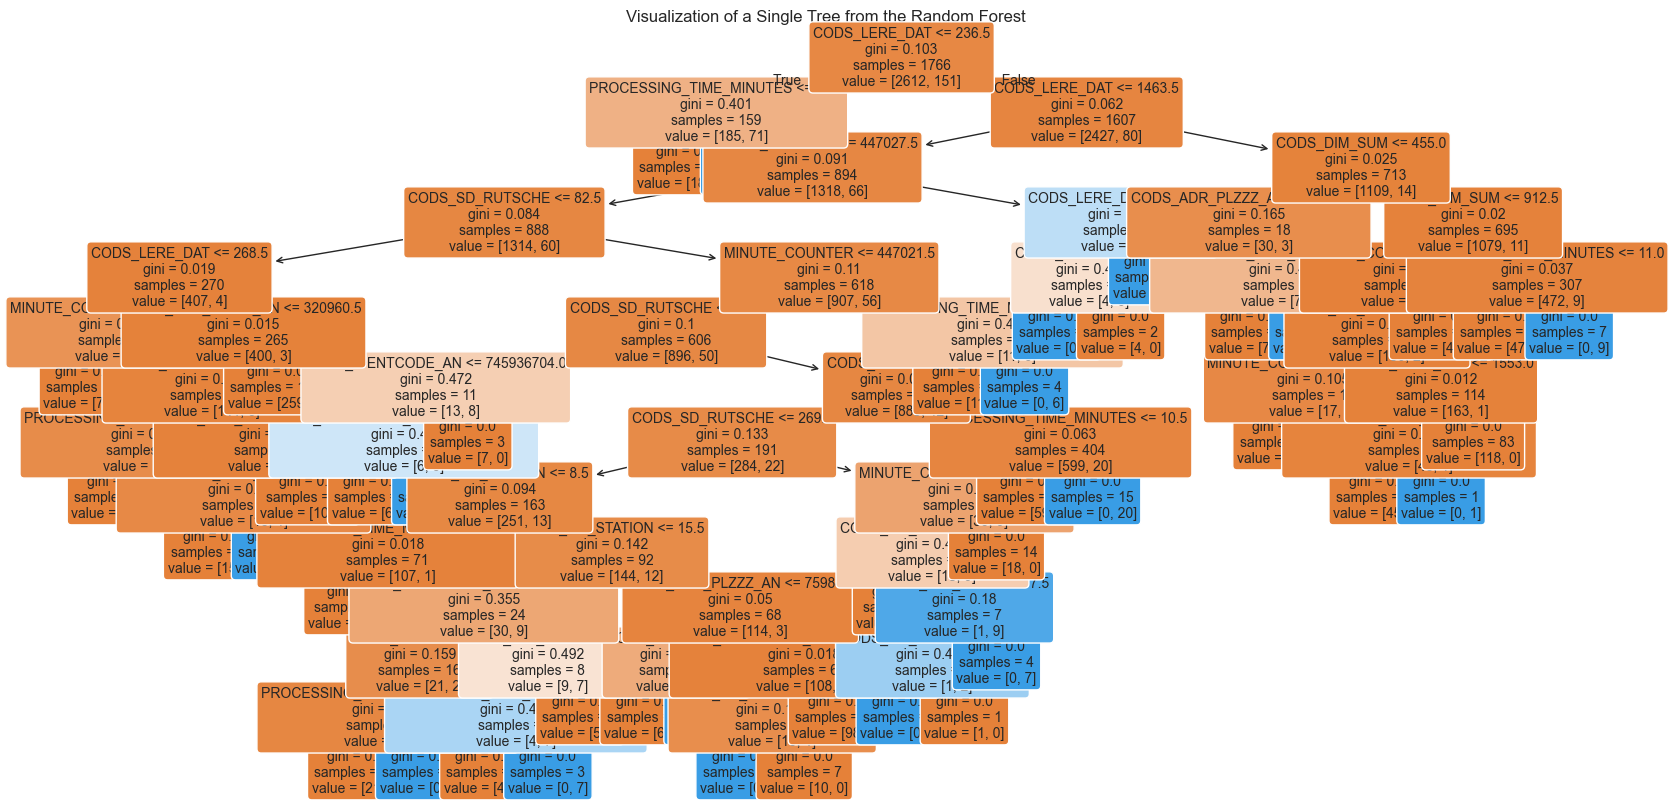

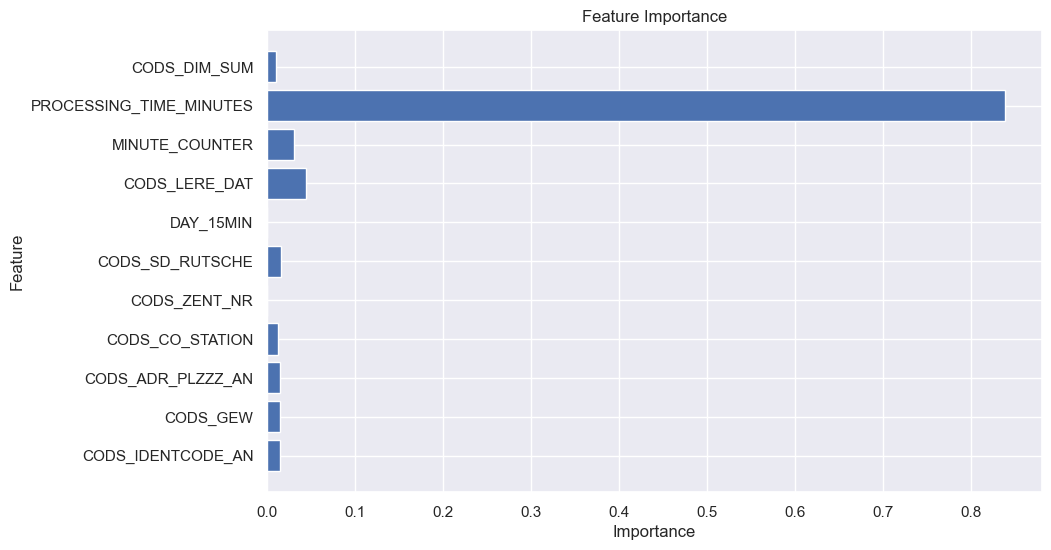

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import export_graphviz, plot_tree

target_column = 'SORTING_PERF_ISSUE'

# Separate features and target
X = data[categorical_features + numerical_features]
y = data[target_column]


# Separate features and target
features = data.drop(columns=[target_column])
target = data[target_column]

# Handle categorical variables with Label Encoding
categorical_columns = features.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col])
    label_encoders[col] = le

# Encode target variable if it's categorical
if target.dtype == 'object' or target.dtype.name == 'category':
    target_encoder = LabelEncoder()
    target = target_encoder.fit_transform(target)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize one of the trees in the forest using plot_tree
tree_index = 0  # Index of the tree to visualize
selected_tree = rf_model.estimators_[tree_index]

plt.figure(figsize=(20, 10))
plot_tree(
    selected_tree,
    feature_names=features.columns,
    class_names=target_encoder.classes_ if 'target_encoder' in locals() else None,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Visualization of a Single Tree from the Random Forest")
plt.show()

# Plot Feature Importance
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features.columns, importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Accuracy

The high accuracy of the model might be due to overfitting or a bias for one of the features.

## Feature Importance
It is clear that the "PROCESSING_TIME_MINUTES" is the feature with clearly the most impact on the model and indicates that this probably contains the most predictive information and is highly correlated with the target.

## Next steps
1. Validate Model Performance:

Test the model on unseen data to ensure it generalizes well and is not overfitting to the dominant feature.

2. Investigate the Target Variable:

Examine how PROCESSING_TIME_MINUTES interacts with the target variable. Are there clear thresholds or relationships?

3. Re-run the Model with Reduced Features:

Train the model without less important features and compare performance metrics. If the performance is similar, you can safely remove those features.

4. Domain Knowledge:

Leverage domain expertise to understand the importance of PROCESSING_TIME_MINUTES and other features.